In [1]:
# First attempt to train a model based on images generated

import os
import cv2
import numpy as np
import random

from tensorflow import keras

import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Conv2D, Concatenate, Embedding, Reshape, Flatten, Activation
from keras.optimizers import SGD

#constants to resize image to
HEIGHT = 90
WIDTH = 160


YAW_ADJ_DEGREES = 35 # e.g. goes from -35 to +35


#get a lsit of files
mypath = 'C:/SelfDrive/GPS with Vision/_img'
images = [f.split('.png')[0] for f in os.listdir(mypath) if f.endswith(".png")]

random.shuffle(images)
# get a list when both are available: image and steering

# read training data 

X = [] #images
X1 = [] # gen direction
Y = [] #expected steering for this image
for example in images:
    img_path = mypath+'/'+example+'.png'
    image = cv2.imread(img_path,cv2.IMREAD_COLOR)
    # option to make images smaller
    image = cv2.resize(image, (WIDTH,HEIGHT))
    # this version adds taking lower side of the image
    X.append(image / 255) # adding another dimension and normalising pixels to 0-1
    # gen direction values are taken from after 1st '_' in file name
    X1.append(int(example.split('_')[1]))
    # y labels are taken from after 2nd '_' in file name
    y = float(example.split('_')[2])
    # convert to a fraction of 90 degrees so -1 is all the way left and + 1 is all the way right
    if y >35:
        y = 35
    elif y<-35:
        y = -35
    
    y = float(y)/YAW_ADJ_DEGREES # rescale to -1 to +1 so -1 is when max left 35degrees and +1 is +35deg
    Y.append(y)

#convert to numpy arrays
X = np.array(X)
X1 = np.array(X1)
Y = np.array(Y)

def create_model():
    # Image input
    image_input = Input(shape=(HEIGHT, WIDTH, 3))
    # Integer input
    integer_input = Input(shape=(1,))
    
    # Preprocess the image input
    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(image_input)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)

    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(processed_image)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)

    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(processed_image)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)

    processed_image = Flatten()(processed_image)
    
    # Concatenate image features with integer input
    concatenated_inputs = Concatenate()([processed_image, integer_input])
    
    # Dense layers for prediction
    x = Dense(64, activation='relu')(concatenated_inputs)
    output = Dense(1, activation='linear')(x)
    
    # Create the model
    model = Model(inputs=[image_input, integer_input], outputs=output)
    
    return model

model = create_model()

model.summary()

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['MSE'])


model.fit([X, X1], Y, batch_size=16, shuffle=False, epochs=30, validation_split=0.2)

predictions = model.predict([X,X1])
print("Prediction min: ",predictions.min()," Prediction max: ",predictions.max())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 90, 160, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 90, 160, 64)  1792        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 45, 80, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 45, 80, 64)   36928       ['max_pooling2d[0][0]']      

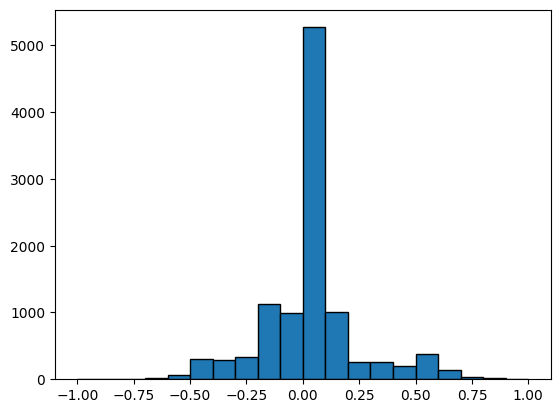

In [2]:
# Let's check distribution of our labels 
from matplotlib import pyplot as plt

frq, edges = np.histogram(Y, bins=20)
fig, ax = plt.subplots()
ax.bar(edges[:-1], frq, width=np.diff(edges), edgecolor="black", align="edge")

plt.show()

#This shows a clear inbalance of labels - the model will learn to go straight

In [1]:
# Second attempt to train a model based on images generated
# here we will try to weigh down over-represented "drive straight" images
# I used weighted_binary_crossentropy function BUT it HAS NOT worked
# probably because it is for classification rather than regression

import os
import cv2
import numpy as np
import random

from tensorflow import keras
from keras import backend as K
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Conv2D, Concatenate, Embedding, Reshape, Flatten, Activation
from keras.optimizers import SGD

#constants to resize image to
HEIGHT = 90
WIDTH = 160


YAW_ADJ_DEGREES = 35 # e.g. goes from -35 to +35


#get a lsit of files
mypath = 'C:/SelfDrive/GPS with Vision/_img'
images = [f.split('.png')[0] for f in os.listdir(mypath) if f.endswith(".png")]

random.shuffle(images)
# get a list when both are available: image and steering

# read training data 

X = [] #images
X1 = [] # gen direction
Y = [] #expected steering for this image
for example in images:
    img_path = mypath+'/'+example+'.png'
    image = cv2.imread(img_path,cv2.IMREAD_COLOR)
    # option to make images smaller
    image = cv2.resize(image, (WIDTH,HEIGHT))
    # this version adds taking lower side of the image
    X.append(image / 255) # adding another dimension and normalising pixels to 0-1
    # gen direction values are taken from after 1st '_' in file name
    X1.append(int(example.split('_')[1]))
    # y labels are taken from after 2nd '_' in file name
    y = float(example.split('_')[2])
    # convert to a fraction of 90 degrees so -1 is all the way left and + 1 is all the way right
    if y >35:
        y = 35
    elif y<-35:
        y = -35
    
    y = float(y)/YAW_ADJ_DEGREES # rescale to -1 to +1 so -1 is when max left 35degrees and +1 is +35deg
    Y.append(y)

#convert to numpy arrays
X = np.array(X)
X1 = np.array(X1)
Y = np.array(Y)

# this is a function I used before in semantic segmentation training
def weighted_binary_crossentropy( y_true, y_pred, weight=1. ) :
    y_true = K.clip(y_true, K.epsilon(), 1-K.epsilon())
    y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
    logloss = -(y_true * K.log(y_pred) * weight + (1 - y_true) * K.log(1 - y_pred))
    return K.mean( logloss, axis=-1)

def create_model():
    # Image input
    image_input = Input(shape=(HEIGHT, WIDTH, 3))
    # Integer input
    integer_input = Input(shape=(1,))
    
    # Preprocess the image input
    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(image_input)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)

    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(processed_image)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)

    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(processed_image)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)

    processed_image = Flatten()(processed_image)
    
    # Concatenate image features with integer input
    concatenated_inputs = Concatenate()([processed_image, integer_input])
    
    # Dense layers for prediction
    x = Dense(64, activation='relu')(concatenated_inputs)
    output = Dense(1, activation='linear')(x)
    
    # Create the model
    model = Model(inputs=[image_input, integer_input], outputs=output)
    
    return model

model = create_model()

model.summary()

model.compile(loss=weighted_binary_crossentropy,
              optimizer='adam',
              metrics=['MSE'])


model.fit([X, X1], Y, batch_size=16, shuffle=False, epochs=30, validation_split=0.2)

predictions = model.predict([X,X1])
print("Prediction min: ",predictions.min()," Prediction max: ",predictions.max())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 90, 160, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 90, 160, 64)  1792        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 45, 80, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 45, 80, 64)   36928       ['max_pooling2d[0][0]']      

This is how training set is distributed:


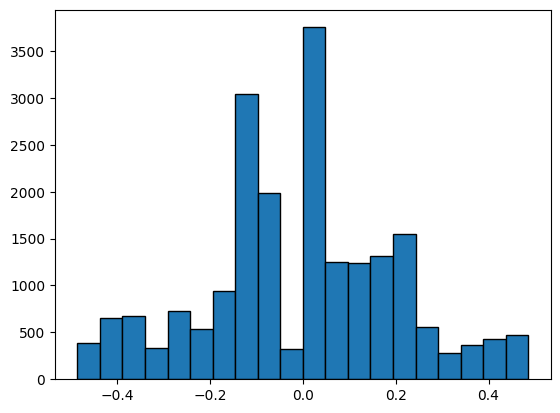

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 180, 320, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 90, 160, 64)  0           ['conv2d[0][0]']                 
                                                                                              

In [71]:
# attempt 3
# we will chop the training set limiting images with straight steering

import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from tensorflow import keras

import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Conv2D, Concatenate, Embedding, Reshape, Flatten, Activation
from keras.optimizers import SGD

#disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

#constants to resize image to
HEIGHT = 180
WIDTH = 320

YAW_ADJ_DEGREES = 35 # e.g. goes from -35 to +35

EVERY_WHAT = 5 # we will keep every n'th image with zero angle 

#get a lsit of files
mypath = 'C:/SelfDrive/GPS with Vision/_img'
images = [f.split('.png')[0] for f in os.listdir(mypath) if f.endswith(".png")]

random.shuffle(images)

X = [] #images
X1 = [] # gen direction
Y = [] #expected steering for this image
straight_counter = 0 # we will be counting images to limit by applying "every n'th"
for example in images:
    img_path = mypath+'/'+example+'.png'
    image = cv2.imread(img_path,cv2.IMREAD_COLOR)
    # option to make images smaller
    image = cv2.resize(image, (WIDTH,HEIGHT))
    
    # y labels are taken from after 2nd '_' in file name
    y = float(example.split('_')[2])
    # convert to a fraction of 90 degrees so -1 is all the way left and + 1 is all the way right
    if y >35:
        y = 35
    elif y<-35:
        y = -35
    
    y = float(y)/YAW_ADJ_DEGREES # rescale to -1 to +1 so -1 is when max left 35degrees and +1 is +35deg
    # a rough balancing by reducing number of zero steer examples
    if (abs(y)>0.05 or straight_counter % EVERY_WHAT ==0) and abs(y)<0.5:
        X.append(image / 255) # adding another dimension and normalising pixels to 0-1
        # gen direction values are taken from after 1st '_' in file name
        X1.append(int(example.split('_')[1]))
        Y.append(y)
    if abs(y)>=0.05:
        straight_counter +=1
#convert to numpy arrays
X = np.array(X)
X1 = np.array(X1)
Y = np.array(Y)


# draw how Y is distributed befored going into training
frq, edges = np.histogram(Y, bins=20)
fig, ax = plt.subplots()
ax.bar(edges[:-1], frq, width=np.diff(edges), edgecolor="black", align="edge")
print('This is how training set is distributed:')
plt.show()

def create_model():
    # Image input
    image_input = Input(shape=(HEIGHT, WIDTH, 3))
    # Integer input
    integer_input = Input(shape=(1,))
    
    # Preprocess the image input
    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(image_input)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)

    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(processed_image)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)

    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(processed_image)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)

    processed_image = Flatten()(processed_image)
    
    # Concatenate image features with integer input
    concatenated_inputs = Concatenate()([processed_image, integer_input])
    
    # Dense layers for prediction
    x = Dense(64, activation='relu')(concatenated_inputs)
    output = Dense(1, activation='linear')(x)
    
    # Create the model
    model = Model(inputs=[image_input, integer_input], outputs=output)
    
    return model

model = create_model()

model.summary()

model.compile(loss='MSE',
              optimizer='adam',
              metrics=['MSE'])


#model.fit([X, X1], Y, batch_size=16, shuffle=False, epochs=30, validation_split=0.2)

#predictions = model.predict([X,X1])
#print("Prediction min: ",predictions.min()," Prediction max: ",predictions.max())

In [2]:
# to save model
model.save("GPS_Visual_Model_overfit", overwrite=True,include_optimizer=True,
    save_format=None, signatures=None, options=None, save_traces=True)

INFO:tensorflow:Assets written to: GPS_Visual_Model_overfit\assets


INFO:tensorflow:Assets written to: GPS_Visual_Model_overfit\assets


In [2]:
# attempt 4
# we will balance the training set across steering angles and will only keep -0.5 to +0.5 examples

# but this version runs out of memory

import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from tensorflow import keras

import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Conv2D, Concatenate, Embedding, Reshape, Flatten, Activation
from keras.optimizers import SGD

#disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

#constants to resize image to
HEIGHT = 180
WIDTH = 320

YAW_ADJ_DEGREES = 35 # e.g. goes from -35 to +35

def balance_array(bin_start,bin_end,bin_size):
    '''
    This function returns indicies of selected elements 
    which make the training set balanced
    You need to apply the returned index to all training arrays  
    '''
    num_bins = int((bin_end - bin_start) / bin_size) + 1
    min_count = np.min(np.histogram(Y, bins=num_bins, range=(bin_start, bin_end))[0])
    balanced_array = []
    selected = []

    for start in np.arange(bin_start, bin_end, bin_size):
        end = start + bin_size
        indices = np.where((Y >= start) & (Y < end))[0]
        #balanced_array.extend(Y[indices[:min_count]])
        selected.extend(indices[:min_count])
    return selected

#get a lsit of files
mypath = 'C:/SelfDrive/GPS with Vision/_img'
images = [f.split('.png')[0] for f in os.listdir(mypath) if f.endswith(".png")]

random.shuffle(images)

X = [] #images
X1 = [] # gen direction
Y = [] #expected steering for this image
for example in images:
    img_path = mypath+'/'+example+'.png'
    image = cv2.imread(img_path,cv2.IMREAD_COLOR)
    # option to make images smaller
    image = cv2.resize(image, (WIDTH,HEIGHT))
    
    # y labels are taken from after 2nd '_' in file name
    y = float(example.split('_')[2])
    # convert to a fraction of 90 degrees so -1 is all the way left and + 1 is all the way right
    if y >35:
        y = 35
    elif y<-35:
        y = -35
    
    y = float(y)/YAW_ADJ_DEGREES # rescale to -1 to +1 so -1 is when max left 35degrees and +1 is +35deg
    # a rough balancing by reducing number of zero steer examples
    X.append(image / 255) # adding another dimension and normalising pixels to 0-1
    # gen direction values are taken from after 1st '_' in file name
    X1.append(int(example.split('_')[1]))
    Y.append(y)

#convert to numpy arrays
X = np.array(X)
X1 = np.array(X1)
Y = np.array(Y)

balanced_subset = balance_array(-0.5,0.5,0.05)

X = X[balanced_subset]
X1 = X1[balanced_subset]
Y = Y[balanced_subset]

# draw how Y is distributed befored going into training
frq, edges = np.histogram(Y, bins=20)
fig, ax = plt.subplots()
ax.bar(edges[:-1], frq, width=np.diff(edges), edgecolor="black", align="edge")
print('This is how training set is distributed:')
plt.show()

def create_model():
    # Image input
    image_input = Input(shape=(HEIGHT, WIDTH, 3))
    # Integer input
    integer_input = Input(shape=(1,))
    
    # Preprocess the image input
    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(image_input)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)

    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(processed_image)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)

    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(processed_image)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)

    processed_image = Flatten()(processed_image)
    
    # Concatenate image features with integer input
    concatenated_inputs = Concatenate()([processed_image, integer_input])
    
    # Dense layers for prediction
    x = Dense(64, activation='relu')(concatenated_inputs)
    output = Dense(1, activation='linear')(x)
    
    # Create the model
    model = Model(inputs=[image_input, integer_input], outputs=output)
    
    return model

model = create_model()

model.summary()

model.compile(loss='MSE',
              optimizer='adam',
              metrics=['MSE'])


model.fit([X, X1], Y, batch_size=16, shuffle=False, epochs=10, validation_split=0.2)

predictions = model.predict([X,X1])
print("Prediction min: ",predictions.min()," Prediction max: ",predictions.max())

MemoryError: Unable to allocate 109. GiB for an array with shape (84518, 180, 320, 3) and data type float64

This is how training set is distributed:


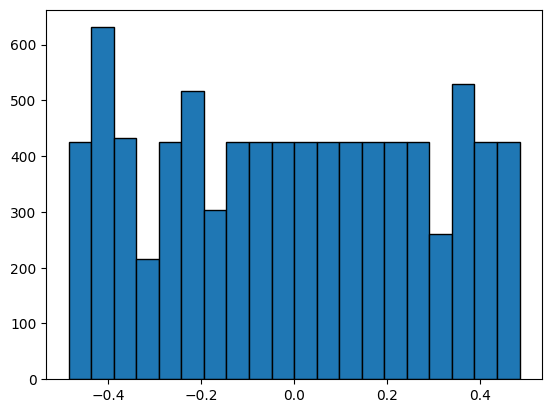

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 180, 320, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 90, 160, 64)  0           ['conv2d[0][0]']                 
                                                                                              

In [1]:
# attempt 5
# we will exclude most of zero steer examples before we add examples to our arrays


import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from tensorflow import keras

import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Conv2D, Concatenate, Embedding, Reshape, Flatten, Activation
from keras.optimizers import SGD
from keras import regularizers

#disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

#constants to resize image to
HEIGHT = 180
WIDTH = 320

YAW_ADJ_DEGREES = 35 # e.g. goes from -35 to +35

EVERY_WHAT = 7

def balance_array(bin_start,bin_end,bin_size):
    '''
    This function returns indicies of selected elements 
    which make the training set balanced
    You need to apply the returned index to all training arrays  
    '''
    num_bins = int((bin_end - bin_start) / bin_size) + 1
    min_count = np.min(np.histogram(Y, bins=num_bins, range=(bin_start, bin_end))[0])
    balanced_array = []
    selected = []

    for start in np.arange(bin_start, bin_end, bin_size):
        end = start + bin_size
        indices = np.where((Y >= start) & (Y < end))[0]
        #balanced_array.extend(Y[indices[:min_count]])
        selected.extend(indices[:min_count])
    return selected

def create_model():
    # Image input
    image_input = Input(shape=(HEIGHT, WIDTH, 3))
    # Integer input
    integer_input = Input(shape=(1,))
    # Preprocess the image input
    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(image_input)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)
    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(processed_image)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)
    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(processed_image)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)
    processed_image = Flatten()(processed_image)
    # Concatenate image features with integer input
    concatenated_inputs = Concatenate()([processed_image, integer_input])
    # Dense layers for prediction
    x = Dense(64, activation='relu')(concatenated_inputs)
    output = Dense(1, activation='linear')(x)
    # Create the model
    model = Model(inputs=[image_input, integer_input], outputs=output)
    return model

#get a lsit of files
mypath = 'C:/SelfDrive/GPS with Vision/_img'
images = [f.split('.png')[0] for f in os.listdir(mypath) if f.endswith(".png")]

random.shuffle(images)

X = [] #images
X1 = [] # gen direction
Y = [] #expected steering for this image
straight_counter = 0 # we will be counting images to limit by applying "every n'th"
for example in images:
    img_path = mypath+'/'+example+'.png'
    image = cv2.imread(img_path,cv2.IMREAD_COLOR)
    # option to make images smaller
    image = cv2.resize(image, (WIDTH,HEIGHT))
    
    # y labels are taken from after 2nd '_' in file name
    y = float(example.split('_')[2])
    # convert to a fraction of 90 degrees so -1 is all the way left and + 1 is all the way right
    if y >35:
        y = 35
    elif y<-35:
        y = -35
    
    y = float(y)/YAW_ADJ_DEGREES # rescale to -1 to +1 so -1 is when max left 35degrees and +1 is +35deg
    if (abs(y)>0.05 or straight_counter % EVERY_WHAT ==0) and abs(y)<0.5:
        X.append(image / 255) # adding another dimension and normalising pixels to 0-1
        # gen direction values are taken from after 1st '_' in file name
        X1.append(int(example.split('_')[1]))
        Y.append(y)
    if abs(y)>=0.05:
        straight_counter +=1

#convert to numpy arrays
X = np.array(X)
X1 = np.array(X1)
Y = np.array(Y)

balanced_subset = balance_array(-0.5,0.5,0.05)

X = X[balanced_subset]
X1 = X1[balanced_subset]
Y = Y[balanced_subset]

# draw how Y is distributed befored going into training
frq, edges = np.histogram(Y, bins=20)
fig, ax = plt.subplots()
ax.bar(edges[:-1], frq, width=np.diff(edges), edgecolor="black", align="edge")
print('This is how training set is distributed:')
plt.show()

model = create_model()

model.summary()

model.compile(loss='MSE',
              optimizer='adam')


model.fit([X, X1], Y, batch_size=16, shuffle=False, epochs=10, validation_split=0.2)

predictions = model.predict([X,X1])
print("Prediction min: ",predictions.min()," Prediction max: ",predictions.max())



In [2]:
model.fit([X, X1], Y, batch_size=64, shuffle=True, epochs=5, validation_split=0.2)

Epoch 1/5
106/106 [==============================] - 438s 4s/step - loss: 0.0627 - MSE: 0.0627 - val_loss: 0.1792 - val_MSE: 0.1792
Epoch 2/5
106/106 [==============================] - 437s 4s/step - loss: 0.0560 - MSE: 0.0560 - val_loss: 0.2070 - val_MSE: 0.2070
Epoch 3/5
106/106 [==============================] - 435s 4s/step - loss: 0.0534 - MSE: 0.0534 - val_loss: 0.2260 - val_MSE: 0.2260
Epoch 4/5
106/106 [==============================] - 435s 4s/step - loss: 0.0525 - MSE: 0.0525 - val_loss: 0.2369 - val_MSE: 0.2369
Epoch 5/5
106/106 [==============================] - 446s 4s/step - loss: 0.0522 - MSE: 0.0522 - val_loss: 0.2442 - val_MSE: 0.2442


In [3]:
# creating a version with regularisers
from keras import regularizers
# adding batch norm
def create_model():
    # Image input
    image_input = Input(shape=(HEIGHT, WIDTH, 3))
    # Integer input
    integer_input = Input(shape=(1,))
    # Preprocess the image input
    x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same',activity_regularizer=regularizers.L2(1e-5))(image_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same',activity_regularizer=regularizers.L2(1e-5))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same',activity_regularizer=regularizers.L2(1e-5))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    # Concatenate image features with integer input
    concatenated_inputs = Concatenate()([x, integer_input])
    # Dense layers for prediction
    x = Dense(64, activation='relu',activity_regularizer=regularizers.L2(1e-5))(concatenated_inputs)
    output = Dense(1, activation='linear')(x)
    # Create the model
    model = Model(inputs=[image_input, integer_input], outputs=output)
    return model

model = create_model()
model.summary()
model.compile(loss='MSE',
              optimizer='adam')
model.fit([X, X1], Y, batch_size=32, shuffle=False, epochs=5, validation_split=0.2)

predictions = model.predict([X,X1])
print("Prediction min: ",predictions.min()," Prediction max: ",predictions.max())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 180, 320, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 90, 160, 64)  0          ['conv2d_3[0][0]']               
                                                                                            